In [31]:
import torch
import re
import torch.nn as nn
import math
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import json

In [32]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Make embeddings relatively larger
        x = x * math.sqrt(self.pe.size(-1))
        # Add constant to embedding
        x = x + self.pe[:x.size(0), :]
        return x


# The CharEmbeddingTransformer model with position encoding
class CharEmbeddingTransformerWithPosEnc(nn.Module):
    def __init__(self, num_chars, d_model, nhead):
        super(CharEmbeddingTransformerWithPosEnc, self).__init__()
        self.embedding = nn.Embedding(num_chars, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.self_attention = SelfAttention(d_model, nhead)
        self.output_layer = nn.Linear(d_model, num_chars)  # Ensure output matches vocab size

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.self_attention(x)
        x = self.output_layer(x)  # Pass through output layer
        return x


# The self-attention class
class SelfAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super(SelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(d_model, nhead)

    def forward(self, x):
        return self.attention(x, x, x)[0]


In [33]:
# Define the model structure
pretrained_embedding_model = CharEmbeddingTransformerWithPosEnc(num_chars=10792, d_model=128, nhead=4)

# Load the model's state dictionary
pretrained_embedding_model = torch.load("/Users/kongzijun/DataspellProjects/chiknowpo_sub/char_embedding_model.pt")
# Set the model to evaluation mode
pretrained_embedding_model.eval()

CharEmbeddingTransformerWithPosEnc(
  (embedding): Embedding(10792, 128)
  (positional_encoding): PositionalEncoding()
  (self_attention): SelfAttention(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
  )
  (output_layer): Linear(in_features=128, out_features=10792, bias=True)
)

In [4]:
list_entries = []
with open('/Users/kongzijun/Downloads/shuowen_副本.txt', 'r', encoding='utf-8') as f :
    for line in f.readlines():
        if not re.match( r'.部', line) :
            list_entries.append(line.rstrip())
char_to_id = {char: idx for idx, char in enumerate(set("".join(list_entries)))}

In [43]:
def create_embeddings(text, model, char_to_id):
    id_sequence = [char_to_id[char] for char in text]
    with torch.no_grad():
        x = model.embedding(torch.tensor(id_sequence).unsqueeze(0))
        x = model.positional_encoding(x)
        embeddings = model.self_attention(x)
    return embeddings

# Example usage
text = "梁宣帝曰"
embeddings1 = create_embeddings(text, pretrained_embedding_model, char_to_id)
print(embeddings1.size())

torch.Size([1, 4, 128])


/Users/kongzijun/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26753 (\N{CJK UNIFIED IDEOGRAPH-6881}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kongzijun/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23459 (\N{CJK UNIFIED IDEOGRAPH-5BA3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kongzijun/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24093 (\N{CJK UNIFIED IDEOGRAPH-5E1D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kongzijun/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26352 (\N{CJK UNIFIED IDEOGRAPH-66F0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


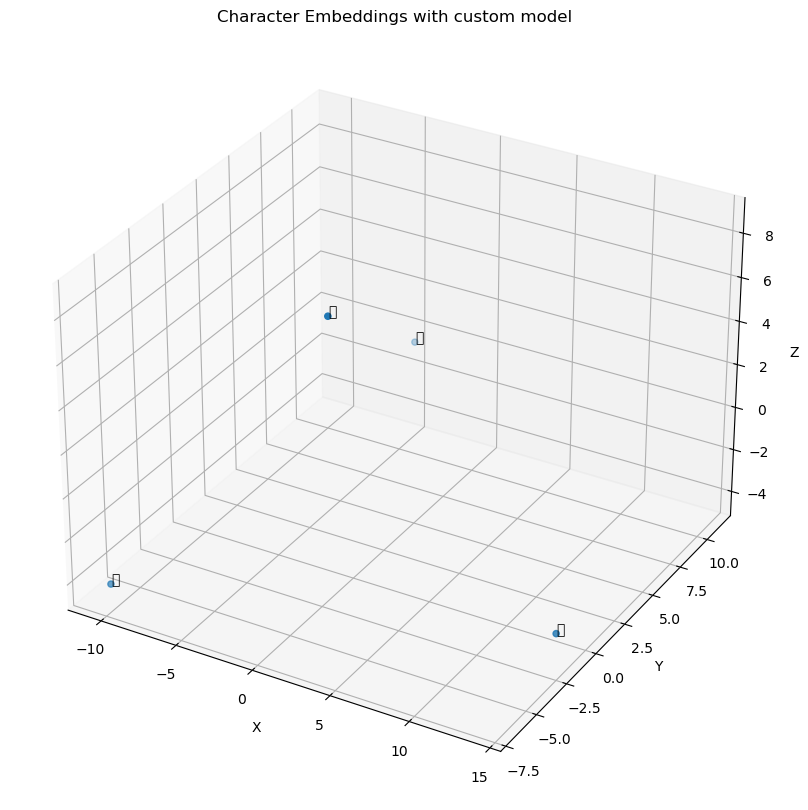

In [48]:
from sklearn.decomposition import PCA

# First, we will visualize embeddings from the first code (embeddings1)

# Use PCA to reduce embeddings to 3D
pca_3d = PCA(n_components=3)
embeddings1_3d = pca_3d.fit_transform(embeddings1.squeeze().numpy())

# Plot the 3D embeddings for embeddings1
fig1 = plt.figure(figsize=(12, 10))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.scatter(embeddings1_3d[:, 0], embeddings1_3d[:, 1], embeddings1_3d[:, 2])

# Annotate each point with its corresponding character
for idx, char in enumerate(text):
    ax1.text(embeddings1_3d[idx, 0], embeddings1_3d[idx, 1], embeddings1_3d[idx, 2], char)

ax1.set_title("Character Embeddings with custom model")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
plt.show()


In [10]:
# Reading data
with open('/Users/kongzijun/Desktop/shuowen_800.json', 'r', encoding='utf-8') as f:
    data_list = json.load(f)

texts = []
tags = []

for data in data_list:
    text = data['text']
    labels = data['label']

    tag_sequence = ['O'] * len(text)

    for label in labels:
        start, end, label_type = label['start'], label['end'], label['labels'][0]
        tag_sequence[start] = f'B-{label_type}'
        for i in range(start + 1, end):
            tag_sequence[i] = f'I-{label_type}'

    texts.append(text)
    tags.append(tag_sequence)

In [12]:
print(texts)

['繠：垂也。从惢糸聲。']


In [11]:
print(tags)

[['B-Head', 'I-Head', 'B-Definition', 'I-Definition', 'I-Definition', 'B-Etymology', 'I-Etymology', 'B-Pronunciation', 'I-Pronunciation', 'I-Pronunciation']]


In [308]:
vocab_size = len(char_to_id) + 1

label_encoder = LabelEncoder()
label_encoder.fit([tag for seq in tags for tag in seq])
num_labels = len(label_encoder.classes_)

In [309]:
class TextDataset(Dataset):
    def __init__(self, texts, tags):
        self.texts = texts
        self.tags = tags

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = torch.tensor([char_to_id[char] for char in self.texts[idx]], dtype=torch.long)
        tag = torch.tensor(label_encoder.transform(self.tags[idx]), dtype=torch.long)
        return text, tag

# split training data and validation data
texts_train, texts_test, tags_train, tags_test = train_test_split(texts, tags, test_size=0.2)
train_dataset = TextDataset(texts_train, tags_train)
test_dataset = TextDataset(texts_test, tags_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [310]:
class BiLSTMWithCustomEmbeddingFixed(nn.Module):
    def __init__(self, char_to_id, d_model, hidden_dim, num_labels):
        super(BiLSTMWithCustomEmbeddingFixed, self).__init__()

        # Use the provided embedding model
        self.embedding_model = pretrained_embedding_model
        self.char_to_id = char_to_id  # Storing the char_to_id as a class attribute

        self.lstm = nn.LSTM(d_model, hidden_dim, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def create_embeddings(self, text_tensor):
        # Convert the tensor back to text
        text = [id_to_char[id] for id in text_tensor[0].numpy()]  # Assuming batch size is 1 as per your DataLoader
        id_sequence = [self.char_to_id[char] for char in text]
        with torch.no_grad():
            x = self.embedding_model.embedding(torch.tensor(id_sequence).unsqueeze(0))
            x = self.embedding_model.self_attention(x)
        return x

    def forward(self, x):
        x = self.create_embeddings(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

# Assuming you've already defined id_to_char as the inverse mapping of char_to_id
id_to_char = {idx: char for char, idx in char_to_id.items()}

In [312]:
def evaluate_model_with_loss(model, criterion, data_loader):
    """Evaluate the model and return predictions, true labels, and loss"""
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_true = []
    total_val_loss = 0

    with torch.no_grad():
        for texts, tags in data_loader:
            outputs = model(texts)
            outputs_reshaped = outputs.view(-1, outputs.shape[-1])
            tags_reshaped = tags.view(-1)

            # Compute validation loss
            val_loss = criterion(outputs_reshaped, tags_reshaped)
            total_val_loss += val_loss.item()

            _, preds = torch.max(outputs_reshaped, 1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_true.extend(tags_reshaped.cpu().numpy().tolist())

    avg_val_loss = total_val_loss / len(data_loader)
    return all_preds, all_true, avg_val_loss

def train_and_evaluate_model_with_val_loss(model, criterion, optimizer, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0

        for batch_idx, (texts, tags) in enumerate(train_loader):
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(texts)

            # Reshape outputs and tags for loss computation
            outputs_reshaped = outputs.view(-1, outputs.shape[-1])
            tags_reshaped = tags.view(-1)

            # Compute the loss
            loss = criterion(outputs_reshaped, tags_reshaped)
            total_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        # Print loss for the epoch
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {total_loss / len(train_loader)}")

        # Evaluate on validation data
        val_preds, val_true, avg_val_loss = evaluate_model_with_loss(model, criterion, val_loader)
        f1 = f1_score(val_true, val_preds, average='weighted')
        acc = accuracy_score(val_true, val_preds)
        print(f"Validation Loss: {avg_val_loss:.4f}, F1 Score: {f1:.4f}, Accuracy: {acc:.4f}")

train_and_evaluate_model_with_val_loss(model, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=0.0001), train_loader, test_loader, epochs=20)

Epoch 1/20, Training Loss: 0.6567952670855448
Validation Loss: 0.9227, F1 Score: 0.6385, Accuracy: 0.6505
Epoch 2/20, Training Loss: 0.652795162703842
Validation Loss: 0.9206, F1 Score: 0.6392, Accuracy: 0.6511
Epoch 3/20, Training Loss: 0.6512334770290181
Validation Loss: 0.9204, F1 Score: 0.6400, Accuracy: 0.6514
Epoch 4/20, Training Loss: 0.6503202037187293
Validation Loss: 0.9192, F1 Score: 0.6409, Accuracy: 0.6514
Epoch 5/20, Training Loss: 0.6498736328212544
Validation Loss: 0.9202, F1 Score: 0.6425, Accuracy: 0.6534
Epoch 6/20, Training Loss: 0.6492887637810781
Validation Loss: 0.9213, F1 Score: 0.6431, Accuracy: 0.6540
Epoch 7/20, Training Loss: 0.6487836967222392
Validation Loss: 0.9206, F1 Score: 0.6418, Accuracy: 0.6524
Epoch 8/20, Training Loss: 0.6487144909799099
Validation Loss: 0.9207, F1 Score: 0.6429, Accuracy: 0.6540
Epoch 9/20, Training Loss: 0.6481625529937446
Validation Loss: 0.9216, F1 Score: 0.6424, Accuracy: 0.6537
Epoch 10/20, Training Loss: 0.6480571285355836


In [13]:
from lxml import etree

root = etree.Element("p")
root.text = "这是一个"
commentary = etree.SubElement(root, "commentary")
commentary.text = "在中部插入评论"
root.tail = "实例"
print(etree.tostring(root, pretty_print=True, encoding='utf-8').decode('utf-8'))

<p>这是一个<commentary>在中部插入评论</commentary></p>实例


In [15]:
def adjust_punctuation_v3(xml_str):
    root = ET.fromstring(xml_str)

    # 定义可能需要移动的标点符号
    punctuation = "。，、；：！？“”‘’"

    # This function is used to move punctuation to the front or back of an element
    def move_punctuation(elem, parent=None):
        if elem.text:
            # If the element text starts with a punctuation
            if elem.text[0] in punctuation:
                if parent is not None and parent.text is not None:
                    parent.text += elem.text[0]
                elif parent is not None:
                    parent.text = elem.text[0]
                else:  # if it's a top-level element
                    elem.text = elem.text[0] + (elem.text or "")
                elem.text = elem.text[1:]

            # If the element text ends with a punctuation
            if elem.text and elem.text[-1] in punctuation:
                if elem.tail is None:
                    elem.tail = ""
                elem.tail += elem.text[-1]
                elem.text = elem.text[:-1]

    # We'll use a recursive function to iterate through all elements while keeping track of the parent
    def recursive_iter(elem, parent=None):
        move_punctuation(elem, parent)
        for child in elem:
            recursive_iter(child, elem)

    recursive_iter(root)

    return ET.tostring(root, encoding='unicode')

modified_xml_v3 = adjust_punctuation_v3(xml_str)
modified_xml_v3


'<p>“<sub>文本</sub>”</p>'